# _'Friday Night is Prenton Night!'_: A simple analysis of Tranmere Rovers Football Club's tradition of Friday Night Football

A curious quirk of Tranmere Rovers Football Club is its historical association with playing home matches on Friday nights instead of Saturday afternoons.

'Friday Night Football' is an initative that was introduced to try and attract supporters that would otherwise be watching Rovers' bigger, more glamorous Merseyside neighbours, Liverpool and Everton, on Saturday afternoons.

Friday Night Football still occurs at Prenton Park, but much less frequently than in the past.

This notebook contains a basic analysis of Friday league matches played at Rovers' home stadium, Prenton Park, between 1921/22 and 2021/22. The questions I sought to address can be separated into two parts:

**Part 1: The Rise and Fall of Friday Night Football**

* How many Friday matches have taken place in each of the seasons between 1921/22 and 2021/22?
* How do they break down by decade?

**Part 2: Managerial Records in Friday Matches**

* Which managers have taken charge of the most Friday matches?
* Which managers have the best points-per-game records in Friday games?

### DATA SOURCES

I acquired the data for this analysis from two websites:

* Results data was scraped from [11v11.com](https://www.11v11.com/teams/tranmere-rovers/tab/matches/season/2022/).
* Manager data (name, start date and end date) was scraped from [Soccerbase](https://www.soccerbase.com/teams/team.sd?team_id=2598&teamTabs=managers).

These two datasets were joined together to create the csv used in this analysis, `results.csv`.

This dataset contains information about all games played between 1921/22 and 2021/22.

# ANALYSIS

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('results.csv', parse_dates=['game_date'])

### Initial filtering of dataframe
This analysis focuses solely on league matches played at Tranmere's home stadium on a Friday.

Matches played in other competitions, at other locations on other days are irrelevant, so `df` is filtered accordingly.

In [3]:
df = df.copy()[(df.weekday == "Friday") &
        (df.game_type == "League") &
        (df.venue == "H") &
        (~df.competition.str.contains("Play")) &
        (~df.competition.str.contains("FA Trophy"))]

df.head()

,season,game_date,opposition,venue,score,home_team,away_team,outcome,home_goals,away_goals,...,11v11_match_url,attendance,stadium,league_tier,goal_diff,game_type,ssn_game_no,ssn_comp_game_no,weekday,manager
13,2021/22,2021-10-08,Colchester United,H,2-0,Tranmere Rovers,Colchester United,W,2,0,...,https://www.11v11.com//matches/tranmere-rovers...,7324.0,Prenton Park,4.0,2,League,14,11,Friday,Micky Mellon
110,2019/20,2019-10-18,Southend United,H,1-1,Tranmere Rovers,Southend United,D,1,1,...,https://www.11v11.com//matches/tranmere-rovers...,7066.0,Prenton Park,3.0,0,League,15,13,Friday,Micky Mellon
156,2018/19,2018-10-12,Macclesfield Town,H,1-0,Tranmere Rovers,Macclesfield Town,W,1,0,...,https://www.11v11.com//matches/tranmere-rovers...,6797.0,Prenton Park,4.0,1,League,16,13,Friday,Micky Mellon
185,2018/19,2019-03-08,Crewe Alexandra,H,1-0,Tranmere Rovers,Crewe Alexandra,W,1,0,...,https://www.11v11.com//matches/tranmere-rovers...,7898.0,Prenton Park,4.0,1,League,45,36,Friday,Micky Mellon
192,2018/19,2019-04-19,Forest Green Rovers,H,0-1,Tranmere Rovers,Forest Green Rovers,L,0,1,...,https://www.11v11.com//matches/tranmere-rovers...,9468.0,Prenton Park,4.0,-1,League,52,43,Friday,Micky Mellon


## Part 1: The Rise and Fall of Friday Night Football

### Question 1a: How many Friday matches have taken place in each of the seasons between 1921/22 and 2021/22?

Our first objective is just to get a grasp of the number of Friday games played in each season.

In [4]:
season_counts = df.season.value_counts() \
    .sort_index() \
    .reset_index() \
    .rename(columns = {
            'index': 'season',
            'season': 'game_count'})

season_counts.head()

,season,game_count
0,1921/22,1
1,1922/23,1
2,1923/24,1
3,1924/25,1
4,1925/26,2


<AxesSubplot:xlabel='season'>

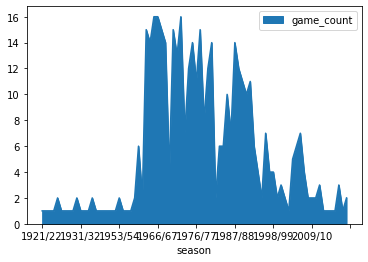

In [5]:
season_counts.plot(kind='area', x = 'season', y = 'game_count')

The data here is not quite enough for our purposes because it only includes seasons where at least one Friday game was played.

To address this, I created a new dataframe that creates a list of every season from 1921/22 to 2021/22.

I then did a left join with `season_counts` and replaced `NaN` with zero for seasons where there were no Friday games.

(N.B. I considered reading in the original csv and running `new_df.season.unique()` on the full, unfiltered list of matches. I decided not to do thsi because while it would have returned seasons where no Friday matches were played, it would not have accounted for years where games were not played due to world wars.)

In [6]:
def define_season(start_year, end_year):
    season_start = str(start_year)
    season_end = str(end_year)[2:]
    season = f'{season_start}/{season_end}'
    return season

seasons = pd.DataFrame({
                        'season_start': range(1921,2022),
                        'season_end': range(1922,2023)
                       })

season_list = seasons.apply(lambda x: define_season(x['season_start'], x['season_end']), axis = 1).to_frame().rename(columns = {0: 'season'})

season_counts_all = season_list.merge(season_counts, how = 'left', on = 'season').fillna(0)

# Note game_count of zero for 2017/18 and 2020/21
season_counts_all.tail()

,season,game_count
96,2017/18,0.0
97,2018/19,3.0
98,2019/20,1.0
99,2020/21,0.0
100,2021/22,2.0


In [7]:
# Create a CSV of the season_counts data to use in Datawrapper
season_counts_all.to_csv('season_counts.csv', index = False)

### Question 1b: How do counts of Friday matches break down by decade?

N.B. The code below felt very clunky and inelegant, and I'm sure there's got to be a more elegant way of achieving what I wanted. I thought I might be able to use `resample(10A)` on `game_date`, but this didn't quite do what I wanted as it did ten years counts for  1922-1931, 1932-1941, etc., rather than 1920-1929, 1930-1939, etc.

<AxesSubplot:xlabel='decade'>

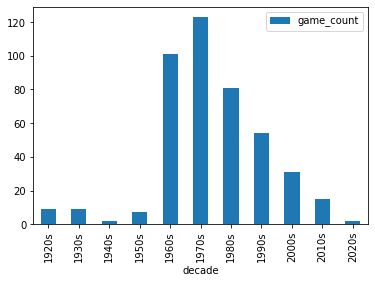

In [8]:
df['year'] = df.game_date.dt.year
df['decade'] = df.year.astype('string').str[0:3]+'0s'

decade_counts = df.decade.value_counts() \
                .sort_index(ascending = True) \
                .reset_index() \
                .rename(columns = {
                        'index': 'decade',
                        'decade': 'game_count'})

decade_counts.plot.bar(x = 'decade', y = 'game_count')

In [9]:
# Create a CSV of the data to use in Datawrapper
decade_counts.to_csv('decade_counts.csv', index = False)

## Part 2: Managerial Records in Friday Matches

In the second part of this analysis, I am seeking to answer two questions:

* Which managers have taken charge of the most Friday matches?
* Which managers have the best points-per-game records in Friday games?

**Adding a `points` columns**

The second of these questions requires us to know the number of points won in Friday matches.

That data does not appear in original dataframe, so we add it, referencing the `outcome` column:

* Three points for a win (`outcome` == 'W')
* One point for a draw (`outcome` == 'D')
* No points for a loss (`outcome` == 'L')

For reference, another way to achiece this would have been to use:

```python
#df['points'] = df.apply(lambda x: 3 if x['outcome'] == 'W' else (1 if x['outcome'] == 'D' else 0), axis = 1)
```

In [10]:
df.loc[df.outcome == 'W', 'points'] = 3
df.loc[df.outcome == 'D', 'points'] = 1
df.loc[df.outcome == 'L', 'points'] = 0

df.head(5)

,season,game_date,opposition,venue,score,home_team,away_team,outcome,home_goals,away_goals,...,league_tier,goal_diff,game_type,ssn_game_no,ssn_comp_game_no,weekday,manager,year,decade,points
13,2021/22,2021-10-08,Colchester United,H,2-0,Tranmere Rovers,Colchester United,W,2,0,...,4.0,2,League,14,11,Friday,Micky Mellon,2021,2020s,3.0
110,2019/20,2019-10-18,Southend United,H,1-1,Tranmere Rovers,Southend United,D,1,1,...,3.0,0,League,15,13,Friday,Micky Mellon,2019,2010s,1.0
156,2018/19,2018-10-12,Macclesfield Town,H,1-0,Tranmere Rovers,Macclesfield Town,W,1,0,...,4.0,1,League,16,13,Friday,Micky Mellon,2018,2010s,3.0
185,2018/19,2019-03-08,Crewe Alexandra,H,1-0,Tranmere Rovers,Crewe Alexandra,W,1,0,...,4.0,1,League,45,36,Friday,Micky Mellon,2019,2010s,3.0
192,2018/19,2019-04-19,Forest Green Rovers,H,0-1,Tranmere Rovers,Forest Green Rovers,L,0,1,...,4.0,-1,League,52,43,Friday,Micky Mellon,2019,2010s,0.0


### Question 2a: Which managers have taken charge of the most Friday matches?

First, I want to take quick look at a summary of managers' records in Friday matches, specifically:

* Number of Friday matches managed (`count`)
* Total points acquired from Friday matches (`sum`)
* Average points won in Friday matches (`mean`)

In [11]:
manager_records = df.groupby('manager').points \
    .agg(['count', 'sum', 'mean']) \
    .reset_index()

manager_records.sort_values('count', ascending=False)

,manager,count,sum,mean
13,John King,136,258.0,1.897059
4,Dave Russell,96,190.0,1.979167
20,Ron Yeats,35,74.0,2.114286
10,Jackie Wright,30,46.0,1.533333
3,Bryan Hamilton,22,34.0,1.545455
12,John Aldridge,19,30.0,1.578947
21,Ronnie Moore,19,26.0,1.368421
0,Bert Cooke,14,34.0,2.428571
7,Frank Worthington,14,12.0,0.857143
2,Brian Little,11,25.0,2.272727


<AxesSubplot:xlabel='manager'>

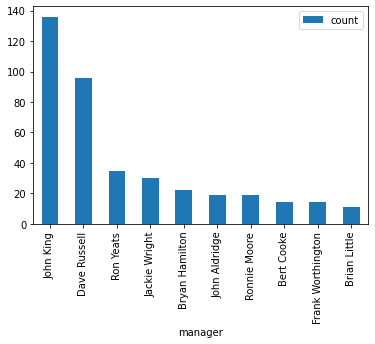

In [12]:
manager_records.sort_values('count', ascending = False).head(10).plot.bar(x = 'manager', y = 'count')

### Question 2b: Which managers have the best points-per-game records in Friday matches?

In [13]:
# Quickly reviewing the data by eye
manager_records.sort_values('mean', ascending = False).drop('sum', axis = 1)

,manager,count,mean
23,Walter Galbraith,4,3.000000
8,Gary Brabin,1,3.000000
1,Bill Ridding,1,3.000000
0,Bert Cooke,14,2.428571
14,Les Parry,3,2.333333
2,Brian Little,11,2.272727
20,Ron Yeats,35,2.114286
11,Jim Knowles,2,2.000000
18,Peter Farrell,2,2.000000
16,Micky Mellon,7,2.000000


From the table above I can see that a number of managers have taken charge of a very small number of Friday night matches.

I therefore decided to filter for managers that have taken charge of at least five Friday night matches.

In [14]:
# Filter for managers that have taken charge of at least five Friday matches
managers_over_5 = manager_records.query("count >= 5").sort_values('mean', ascending = False)
managers_over_5

,manager,count,sum,mean
0,Bert Cooke,14,34.0,2.428571
2,Brian Little,11,25.0,2.272727
20,Ron Yeats,35,74.0,2.114286
16,Micky Mellon,7,14.0,2.000000
4,Dave Russell,96,190.0,1.979167
13,John King,136,258.0,1.897059
6,Ernest Blackburn,7,12.0,1.714286
12,John Aldridge,19,30.0,1.578947
3,Bryan Hamilton,22,34.0,1.545455
10,Jackie Wright,30,46.0,1.533333


<AxesSubplot:xlabel='manager'>

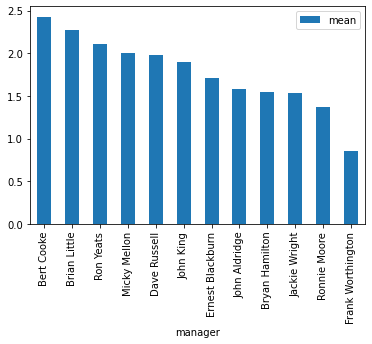

In [15]:
# Make a quick plot to see how the data looks
managers_over_5.plot.bar(x = 'manager', y = 'mean')

In [16]:
# Create a CSV of the data to use in Datawrapper
managers_over_5.to_csv('manager_records.csv', index = False)